In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

# Splits / resampling
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    LeaveOneOut,
    cross_val_score,
    cross_validate
)

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Models
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Feature selection
from sklearn.feature_selection import f_classif

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample  # for bootstrap

# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Reproducibility
rng = np.random.default_rng(42)
pd.set_option("display.max_columns", 200)


In [2]:
df = pd.read_csv("group_20.csv")

display(df.head())

df.info()
print("Shape:", df.shape, "| Duplicates:", df.duplicated().sum())


df["focus_factor"] = pd.to_numeric(df["focus_factor"], errors="coerce")

print(df["focus_factor"].dtype)
print(df["focus_factor"].head())

,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,artist_song_count,album_freq,movement_index,intensity_level,verbal_density,purity_score,positivity_index,activity_rate,loudness_intensity,happy_dance,acoustics_instrumental,artists_avg_popularity,tempo_vs_genre,energy_rank_pct,loud_energy_ratio,mood_pca,mood_cluster,acoustic_valence_mood_cluster,explicit,signal_strength,mode_indicator,focus_factor,ambient_level,key_sin,key_cos,duration_log,duration_log_z,time_signature_class_boolean,loudness_yeo,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,2.0,0.221824,-1.511882,3.055348,0.465097,-0.592367,-0.215943,-0.558508,-0.538032,0.019031,-1.821983,0.231595,-0.342805,-0.291004,1.174469,-2.050394,-1.035640,-0.009063,-0.526052,-0.107785,1.384717,0.0,0.417,0.0,0.022,0.0974,0.000000e+00,1.000000,1.402643,-0.418639,1.0,-0.462119,0.0,0.0,-1.821975,-0.875781,0.516169,1,-0.517458,0.417,class_93,2.634456
1,0.0,0.0,1.0,0.0,0.0,3.0,4.0,1.0,0.221824,1.330170,0.747117,-0.088815,0.260452,1.083433,-0.482845,-0.798166,-0.293396,0.063556,1.096193,-0.235202,-0.301833,2.232929,-0.079104,0.618424,-0.009369,0.171172,-0.775793,0.396063,0.0,0.807,1.0,0.0177,0.1010,-8.660254e-01,0.500000,1.610770,0.299746,1.0,1.547522,0.0,0.0,0.063556,0.434668,0.085216,1,0.352649,0.807,class_93,2.679289
2,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,0.221824,-1.483743,3.752626,-0.429684,0.790583,0.463670,-0.351381,-0.698623,1.353599,0.595310,-0.206955,1.466782,-0.306003,-0.124485,0.476833,0.562618,-0.009394,1.333943,1.562236,0.725614,0.0,0.797,1.0,0.000745,0.0546,0.000000e+00,1.000000,1.245523,-0.960967,1.0,0.359507,0.0,0.0,0.595308,-0.193942,0.135326,1,-0.788285,0.797,class_93,2.813789
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.221824,0.204605,-0.406998,-0.387075,1.228517,0.147723,0.004234,0.421307,1.210885,0.062022,0.464803,1.637574,-0.305989,1.480086,-0.080708,-0.903516,-0.009104,0.686433,-0.775793,-1.251692,0.0,0.460,1.0,0.000141,0.0610,1.224647e-16,-1.000000,1.756630,0.803206,1.0,-0.061056,0.0,0.0,0.062022,0.784308,0.265456,1,0.197067,0.460,class_93,1.648124
4,0.0,0.0,1.0,0.0,0.0,1.0,4.0,1.0,0.221824,1.583423,-0.238689,-0.472292,0.600427,0.262052,-0.380700,-0.501944,0.076888,-0.006161,-0.179153,0.208423,-0.306278,-1.136754,-0.151992,-0.056277,-0.009326,0.225546,1.228232,1.384717,0.0,0.673,0.0,5.29e-05,0.3040,-5.000000e-01,0.866025,1.601809,0.268814,1.0,0.081898,0.0,0.0,-0.006161,-1.300966,0.629706,1,0.174018,0.673,class_93,2.320623


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   duration_1                     3000 non-null   float64
 1   duration_2                     3000 non-null   float64
 2   duration_3                     3000 non-null   float64
 3   duration_4                     3000 non-null   float64
 4   duration_5                     3000 non-null   float64
 5   loudness_level                 3000 non-null   float64
 6   popularity_level               3000 non-null   float64
 7   tempo_class                    3000 non-null   float64
 8   time_signature                 3000 non-null   float64
 9   key_mode                       3000 non-null   float64
 10  artist_song_count              3000 non-null   float64
 11  album_freq                     3000 non-null   float64
 12  movement_index                 3000 non-null   f

In [3]:
# Basic splits
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", cat_cols)

# Check class balance (important for classification task)
print("Class distribution:")
print(df['target_class'].value_counts())

Numeric columns: 48
Categorical columns: ['target_class']
Class distribution:
target_class
class_93     1000
class_105    1000
class_112    1000
Name: count, dtype: int64


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
duration_1,3000.0,0.098667,0.298264,0.0,0.0,0.0,0.0,1.0
duration_2,3000.0,0.180000,0.384252,0.0,0.0,0.0,0.0,1.0
duration_3,3000.0,0.298667,0.457750,0.0,0.0,0.0,1.0,1.0
duration_4,3000.0,0.376000,0.484461,0.0,0.0,0.0,1.0,1.0
duration_5,3000.0,0.046667,0.210959,0.0,0.0,0.0,0.0,1.0


Categorical summary:


,count,unique,top,freq
target_class,3000,3,class_93,1000


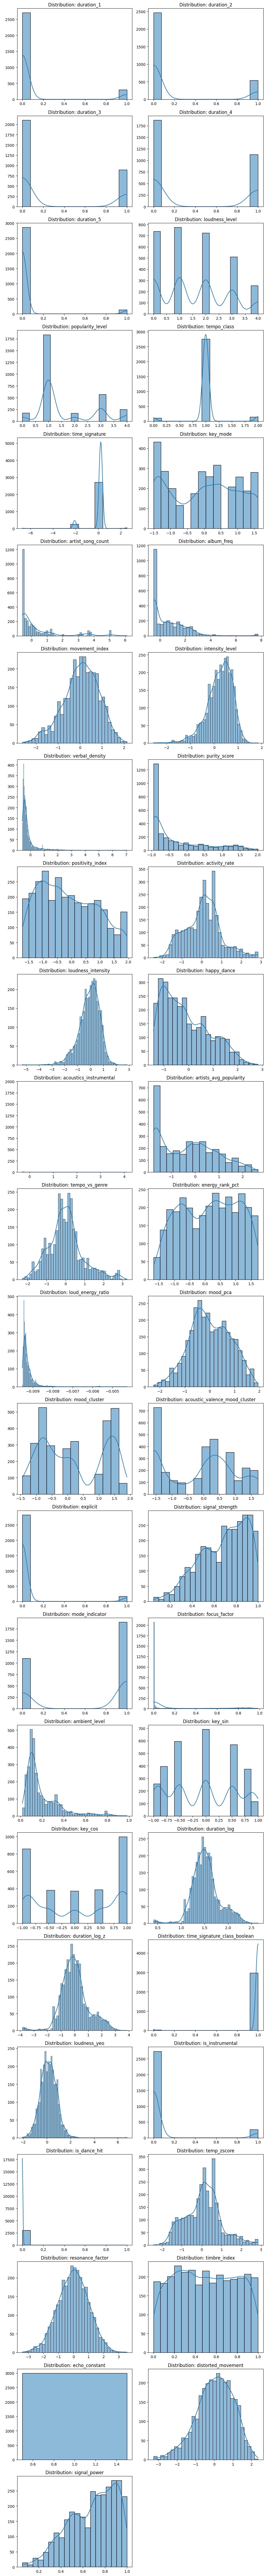

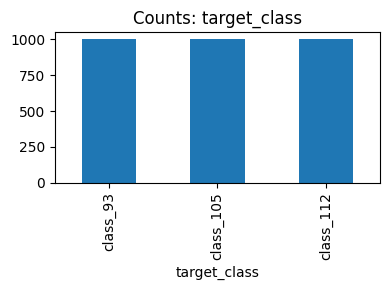

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

desc_num = df[num_cols].describe().T
desc_cat = df[cat_cols].describe().T

print("Numeric summary:")
display(desc_num.head())

print("Categorical summary:")
display(desc_cat)

# === Numeric distributions ===
num_features = [c for c in num_cols if c != 'target_regression']

n_cols = 2
n_rows = math.ceil(len(num_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution: {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Remove empty subplots if any
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === Categorical distributions ===
for col in cat_cols:
    plt.figure(figsize=(4,3))
    df[col].value_counts(dropna=False).plot.bar()
    plt.title(f"Counts: {col}")
    plt.tight_layout()
    plt.show()

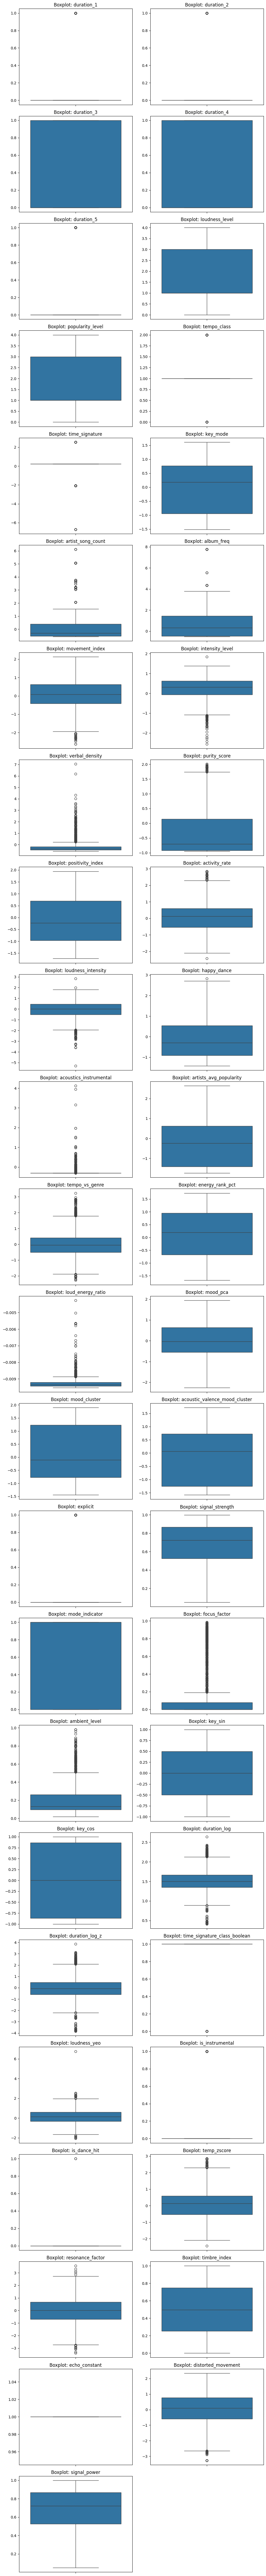

In [5]:
n_cols = 2
n_rows = math.ceil(len(num_features) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot: {col}")
    axes[i].set_xlabel("")  # opcional, para ficar mais limpo
    axes[i].set_ylabel("")

# Remover subplots vazios (se o número de variáveis for ímpar, etc.)
for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

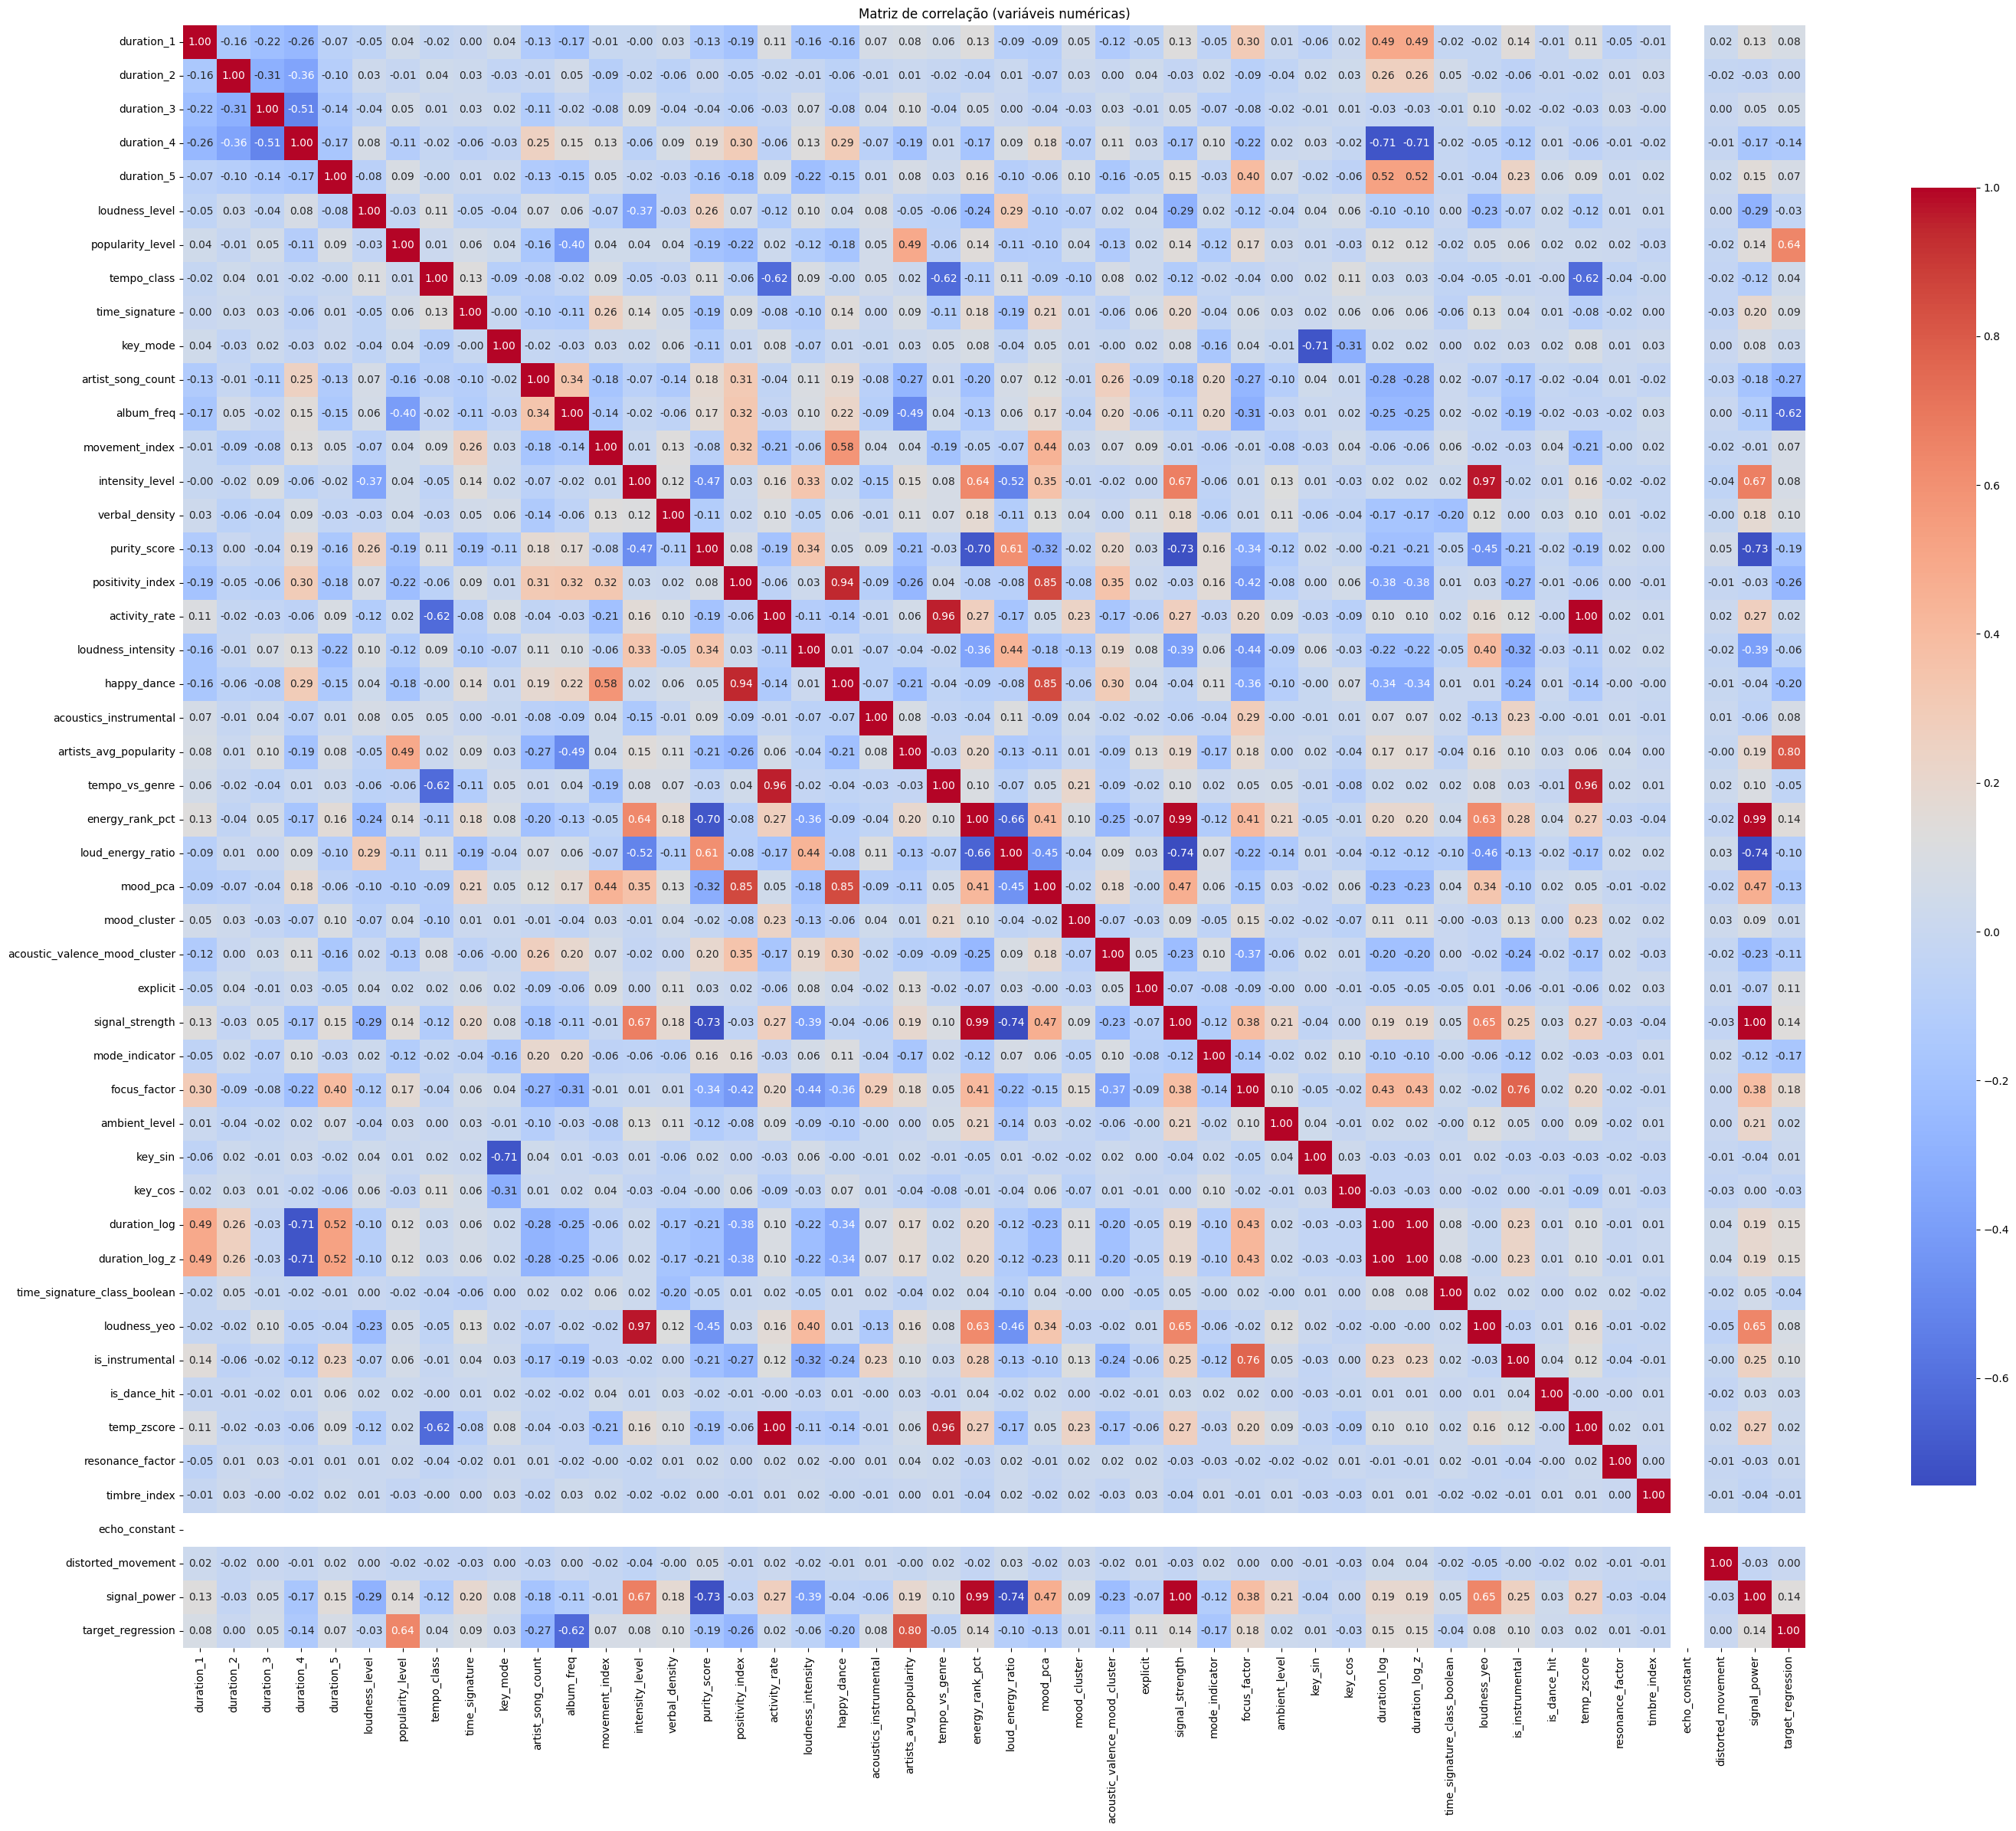

In [6]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(30, 24))
sns.heatmap(
    corr_matrix,
    annot=True,        # mostra os valores numéricos
    fmt=".2f",         # duas casas decimais
    cmap="coolwarm",   # ou outro mapa de cores que prefiras
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de correlação (variáveis numéricas)")
plt.tight_layout()
plt.show()


In [7]:
threshold = 0.95

corr_abs = corr_matrix.abs()

# 2) Considerar apenas a parte superior da matriz (sem diagonal)
mask = np.triu(np.ones(corr_abs.shape), k=1).astype(bool)
corr_upper = corr_abs.where(mask)

# 3) Obter pares com correlação > 0.95 em valor absoluto
high_corr = (
    corr_upper
    .stack()  # transforma em Series com MultiIndex (var1, var2)
    .reset_index()
)
high_corr.columns = ["var1", "var2", "corr_abs"]

high_corr = high_corr[high_corr["corr_abs"] > threshold] \
    .sort_values("corr_abs", ascending=False)

print("Pares de variáveis com |correlação| > 0.95:")
display(high_corr)

# 4) Lista de variáveis que participam em pelo menos um par com |corr| > 0.95
vars_high_corr = sorted(set(high_corr["var1"]).union(set(high_corr["var2"])))
print("Variáveis com correlação (em módulo) > 0.95 com alguma outra variável:")
print(vars_high_corr)

Pares de variáveis com |correlação| > 0.95:


,var1,var2,corr_abs
943,signal_strength,signal_power,1.000000
669,activity_rate,temp_zscore,1.000000
1015,duration_log,duration_log_z,1.000000
810,energy_rank_pct,signal_strength,0.986598
826,energy_rank_pct,signal_power,0.986598
544,intensity_level,loudness_yeo,0.969534
799,tempo_vs_genre,temp_zscore,0.958444
650,activity_rate,tempo_vs_genre,0.958444


Variáveis com correlação (em módulo) > 0.95 com alguma outra variável:
['activity_rate', 'duration_log', 'duration_log_z', 'energy_rank_pct', 'intensity_level', 'loudness_yeo', 'signal_power', 'signal_strength', 'temp_zscore', 'tempo_vs_genre']


In [8]:
# Lista de variáveis a descartar (com |corr| > 0.95 em relação a outras)
to_drop = [
    "signal_power",
    "energy_rank_pct",
    "temp_zscore",
    "tempo_vs_genre",
    "duration_log_z",
    "loudness_yeo",
    "echo_constant"
]


# Se quiseres, podes sobrescrever o df original:
df = df.drop(columns=to_drop)

# Atualizar lista de variáveis numéricas (se já tinhas num_cols definido)
num_cols = df.select_dtypes(include="number").columns.tolist()
print("Número de variáveis numéricas após remoção:", len(num_cols))

Número de variáveis numéricas após remoção: 41


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,artist_song_count,album_freq,movement_index,intensity_level,verbal_density,purity_score,positivity_index,activity_rate,loudness_intensity,happy_dance,acoustics_instrumental,artists_avg_popularity,loud_energy_ratio,mood_pca,mood_cluster,acoustic_valence_mood_cluster,explicit,signal_strength,mode_indicator,focus_factor,ambient_level,key_sin,key_cos,duration_log,time_signature_class_boolean,is_instrumental,is_dance_hit,resonance_factor,timbre_index,distorted_movement,target_regression
duration_1,1.000,-0.155,-0.216,-0.257,-0.073,-0.046,0.042,-0.022,0.005,0.044,-0.131,-0.165,-0.006,-0.003,0.031,-0.129,-0.190,0.110,-0.159,-0.165,0.072,0.083,-0.088,-0.090,0.047,-0.125,-0.047,0.129,-0.051,0.305,0.009,-0.055,0.016,0.491,-0.021,0.142,-0.009,-0.051,-0.014,0.020,0.084
duration_2,-0.155,1.000,-0.306,-0.364,-0.104,0.031,-0.013,0.038,0.025,-0.034,-0.013,0.051,-0.094,-0.016,-0.064,0.001,-0.053,-0.019,-0.011,-0.065,-0.015,0.010,0.008,-0.074,0.030,0.002,0.037,-0.028,0.023,-0.089,-0.040,0.021,0.033,0.257,0.048,-0.060,-0.012,0.013,0.027,-0.017,0.004
duration_3,-0.216,-0.306,1.000,-0.507,-0.144,-0.038,0.054,0.006,0.031,0.022,-0.115,-0.024,-0.083,0.090,-0.043,-0.042,-0.064,-0.034,0.071,-0.082,0.039,0.102,0.002,-0.043,-0.025,0.035,-0.010,0.050,-0.073,-0.078,-0.022,-0.008,0.007,-0.026,-0.005,-0.023,-0.017,0.027,-0.001,0.003,0.055
duration_4,-0.257,-0.364,-0.507,1.000,-0.172,0.075,-0.106,-0.020,-0.057,-0.028,0.255,0.148,0.134,-0.063,0.086,0.187,0.298,-0.060,0.133,0.294,-0.074,-0.189,0.089,0.182,-0.071,0.111,0.029,-0.169,0.096,-0.217,0.018,0.032,-0.016,-0.710,-0.016,-0.120,0.007,-0.009,-0.021,-0.012,-0.139
duration_5,-0.073,-0.104,-0.144,-0.172,1.000,-0.081,0.092,-0.004,0.012,0.017,-0.127,-0.148,0.051,-0.015,-0.030,-0.158,-0.180,0.090,-0.215,-0.148,0.010,0.076,-0.099,-0.061,0.096,-0.157,-0.047,0.151,-0.031,0.398,0.065,-0.016,-0.061,0.524,-0.009,0.233,0.056,0.010,0.022,0.024,0.074
loudness_level,-0.046,0.031,-0.038,0.075,-0.081,1.000,-0.030,0.111,-0.047,-0.043,0.067,0.064,-0.070,-0.369,-0.028,0.255,0.069,-0.116,0.100,0.036,0.076,-0.054,0.294,-0.101,-0.074,0.015,0.038,-0.289,0.022,-0.119,-0.036,0.035,0.063,-0.096,0.003,-0.067,0.019,0.010,0.007,0.001,-0.034
popularity_level,0.042,-0.013,0.054,-0.106,0.092,-0.030,1.000,0.013,0.065,0.036,-0.161,-0.402,0.040,0.044,0.045,-0.188,-0.224,0.024,-0.115,-0.176,0.052,0.494,-0.108,-0.103,0.042,-0.126,0.019,0.143,-0.115,0.172,0.032,0.007,-0.027,0.116,-0.017,0.061,0.020,0.018,-0.027,-0.019,0.641
tempo_class,-0.022,0.038,0.006,-0.020,-0.004,0.111,0.013,1.000,0.128,-0.092,-0.079,-0.023,0.086,-0.052,-0.026,0.105,-0.064,-0.615,0.087,-0.005,0.046,0.016,0.110,-0.094,-0.101,0.075,0.020,-0.119,-0.021,-0.038,0.001,0.022,0.114,0.025,-0.042,-0.013,-0.001,-0.041,-0.004,-0.024,0.044
time_signature,0.005,0.025,0.031,-0.057,0.012,-0.047,0.065,0.128,1.000,-0.005,-0.101,-0.113,0.257,0.138,0.053,-0.189,0.087,-0.082,-0.099,0.143,0.003,0.087,-0.190,0.215,0.014,-0.060,0.057,0.195,-0.042,0.058,0.027,0.019,0.057,0.063,-0.056,0.043,0.007,-0.021,0.003,-0.027,0.089
key_mode,0.044,-0.034,0.022,-0.028,0.017,-0.043,0.036,-0.092,-0.005,1.000,-0.018,-0.030,0.029,0.022,0.065,-0.111,0.012,0.082,-0.065,0.009,-0.007,0.031,-0.037,0.054,0.007,-0.003,0.018,0.078,-0.159,0.044,-0.006,-0.710,-0.310,0.021,0.004,0.028,0.023,0.013,0.031,0.000,0.030


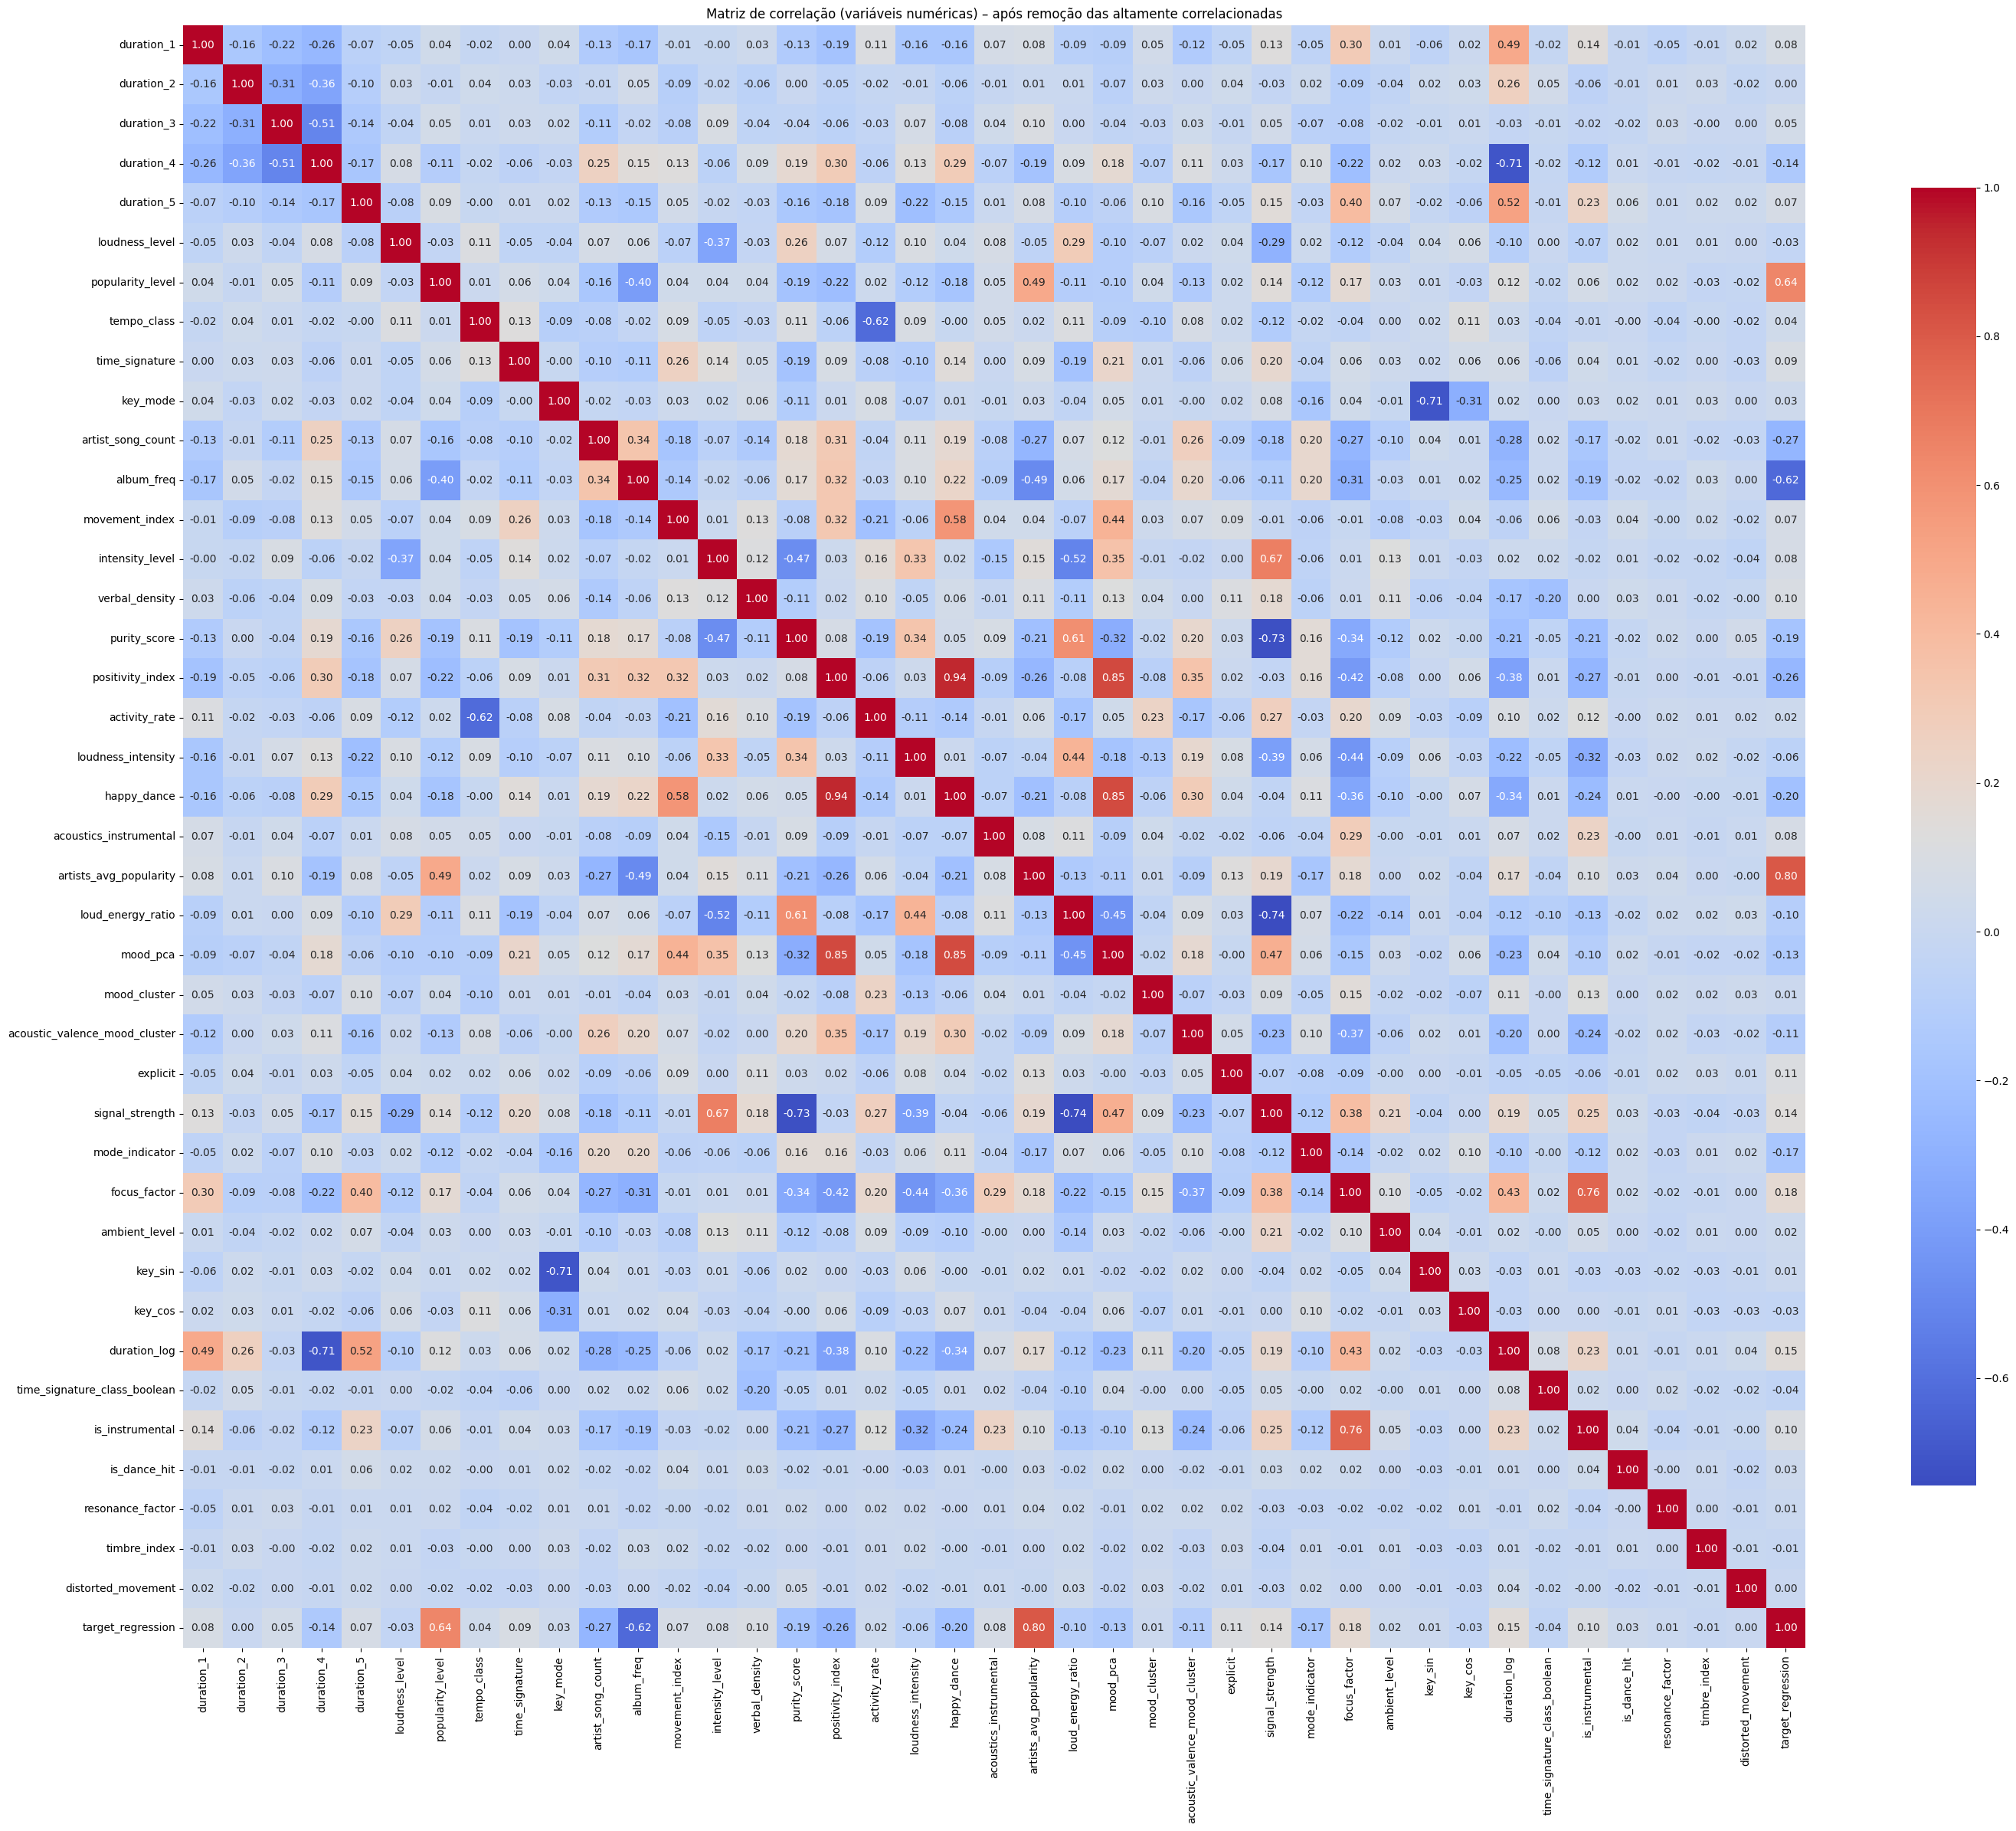

In [9]:
# Recalcular matriz de correlação com o df já limpo
corr_matrix = df[num_cols].corr(method="pearson")

# Visualizar (se quiseres ver em tabela)
display(corr_matrix.round(3))

# Heatmap atualizado
plt.figure(figsize=(30, 24))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de correlação (variáveis numéricas) – após remoção das altamente correlacionadas")
plt.tight_layout()
plt.show()


In [10]:
from sklearn.pipeline import Pipeline

data = df.copy()

target_col = "target_class"   

data = data.dropna(subset=[target_col])

num_cols = data.select_dtypes(include="number").columns.tolist()

feature_cols = [c for c in num_cols if c != target_col]

X = data[feature_cols]
y = data[target_col]

print("Features usadas no LASSO:")
print(feature_cols)

print("\nNº de NaN por variável (antes da imputação):")
print(X.isna().sum()[X.isna().sum() > 0])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

C_values = [0.001, 0.01, 0.1, 0.3, 0.6, 0.8, 1, 2, 4, 6, 8, 10]

best_acc = -np.inf
best_C = None
best_model = None

for C in C_values:
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),  # trata NaN
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            penalty="l1",
            C=C,
            solver="liblinear",  # suporta L1
            max_iter=1000,
            random_state=42
        ))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"C = {C}: accuracy = {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_model = pipe

print("\nMelhor C encontrado:", best_C)
print(f"Melhor accuracy no conjunto de teste: {best_acc:.4f}")


Features usadas no LASSO:
['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'intensity_level', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'loud_energy_ratio', 'mood_pca', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'time_signature_class_boolean', 'is_instrumental', 'is_dance_hit', 'resonance_factor', 'timbre_index', 'distorted_movement', 'target_regression']

Nº de NaN por variável (antes da imputação):
focus_factor    10
dtype: int64
C = 0.001: accuracy = 0.3333
C = 0.01: accuracy = 0.7278
C = 0.1: accuracy = 0.7844
C = 0.3: accuracy = 0.7811
C = 0.6: accuracy = 0.7833
C = 0.8: accuracy = 0.78

In [11]:
#2) Features com coeficiente ≠ 0 e remoção das restantes

logreg = best_model.named_steps["logreg"]

# Coeficientes: shape (n_classes, n_features)
coefs = logreg.coef_

# Para problema multiclasse:
# uma feature é mantida se tiver coeficiente ≠ 0 em pelo menos uma classe
non_zero_mask = (coefs != 0).any(axis=0)

selected_features = np.array(feature_cols)[non_zero_mask].tolist()
dropped_features = np.array(feature_cols)[~non_zero_mask].tolist()

print("\nFeatures selecionadas (coeficiente ≠ 0):")
print(selected_features)

print("\nFeatures removidas pelo LASSO (coeficiente = 0):")
print(dropped_features)

# Criar novo DataFrame apenas com as features selecionadas + target
df_lasso = data[selected_features + [target_col]].copy()

print("\nDimensões originais:", data.shape)
print("Dimensões após LASSO:", df_lasso.shape)


Features selecionadas (coeficiente ≠ 0):
['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'loud_energy_ratio', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'time_signature_class_boolean', 'resonance_factor', 'timbre_index', 'distorted_movement', 'target_regression']

Features removidas pelo LASSO (coeficiente = 0):
['intensity_level', 'mood_pca', 'is_instrumental', 'is_dance_hit']

Dimensões originais: (3000, 42)
Dimensões após LASSO: (3000, 38)
